<a href="https://colab.research.google.com/github/NazninNaharSr/DataScience/blob/main/Flood_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e5:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F73278%2F8121328%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240521%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240521T170622Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6c811f422c858bd7092cb613eb4c2006b7e4f98a8f5f869ff6f223bdf2d89515b9e9c5f0a804eb88c28ed86c6ba3c97e4efc38e8eccde3b9a0d06bd799af2c6321c0780cdad2bcb5926f492b9035374041167ac71b24a04f9702ccaed4e16bf80550d386056f8d5864518d5fc76fb9a069677eaf52b58dc8862b677ed1112992116a3cafc4dc41db37608d882f47823b8cd95370c9d3cba32af20db378d50e3c4ceb9032156694902abca4931c01b30ef3ea0f13b9c82c44e9ae020a3c0c21490d9129ecb519f69b1e35c762520b18ac78cb20e474c1b40bc23898661a8546b9409fc9de432008412b2f984e11fcbb34a50f0f4cbab64d4e7744892dafd6cb6a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 29311374 bytes downloaded
Downloaded and uncompressed: playground-series-s4e5
Data source import complete.


In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/test.csv


# ****Load dataset

In [37]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
train_data.head(10)

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415
5,5,5,4,1,4,2,4,6,6,7,...,3,5,5,4,4,6,8,3,2,0.440
6,6,8,3,1,2,3,7,3,4,6,...,2,5,6,4,5,6,3,4,6,0.460
7,7,6,6,5,7,5,5,3,5,5,...,5,3,5,5,8,6,8,5,6,0.595
8,8,5,2,8,5,4,5,2,4,5,...,9,2,7,3,4,6,4,5,5,0.505
9,9,4,2,3,5,8,6,5,5,7,...,6,3,3,4,4,3,3,5,6,0.455


In [72]:
test_data = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')
test_data.head(10)

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,...,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,...,4,3,2,6,4,6,8,4,5,5
5,1117962,3,4,8,4,6,5,2,5,9,...,6,4,3,7,1,6,6,3,5,6
6,1117963,5,5,6,8,6,5,3,6,9,...,6,4,2,5,5,5,4,6,5,5
7,1117964,6,9,6,5,5,5,3,8,10,...,3,5,6,1,2,5,3,6,4,4
8,1117965,6,5,2,4,6,4,5,8,4,...,4,2,6,6,7,3,3,6,5,2
9,1117966,4,8,8,4,7,7,4,1,3,...,7,8,4,4,7,10,3,6,7,3


In [39]:
#list of columns
print(train_data.columns)

Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')


In [ ]:
#shape of data
#train_data.shape

In [ ]:
#test_data.shape

In [40]:
#check mising values
print(list(train_data.isnull().any()))

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [41]:
#check mising values
print(list(test_data.isnull().any()))

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [42]:
train_data.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


In [43]:
print(train_data.corr().iloc[-1])

id                                -0.000184
MonsoonIntensity                   0.189098
TopographyDrainage                 0.187635
RiverManagement                    0.187131
Deforestation                      0.184001
Urbanization                       0.180861
ClimateChange                      0.184761
DamsQuality                        0.187996
Siltation                          0.186789
AgriculturalPractices              0.183366
Encroachments                      0.178841
IneffectiveDisasterPreparedness    0.183109
DrainageSystems                    0.179305
CoastalVulnerability               0.177774
Landslides                         0.185346
Watersheds                         0.181907
DeterioratingInfrastructure        0.190007
PopulationScore                    0.185890
WetlandLoss                        0.183396
InadequatePlanning                 0.180968
PoliticalFactors                   0.182417
FloodProbability                   1.000000
Name: FloodProbability, dtype: f

In [44]:
#About Target/Flood Probability variable
train_data.FloodProbability.value_counts()

FloodProbability
0.490    43320
0.495    42302
0.520    41266
0.485    41156
0.505    41126
         ...  
0.700       32
0.725       29
0.715       26
0.710       23
0.285       20
Name: count, Length: 83, dtype: int64

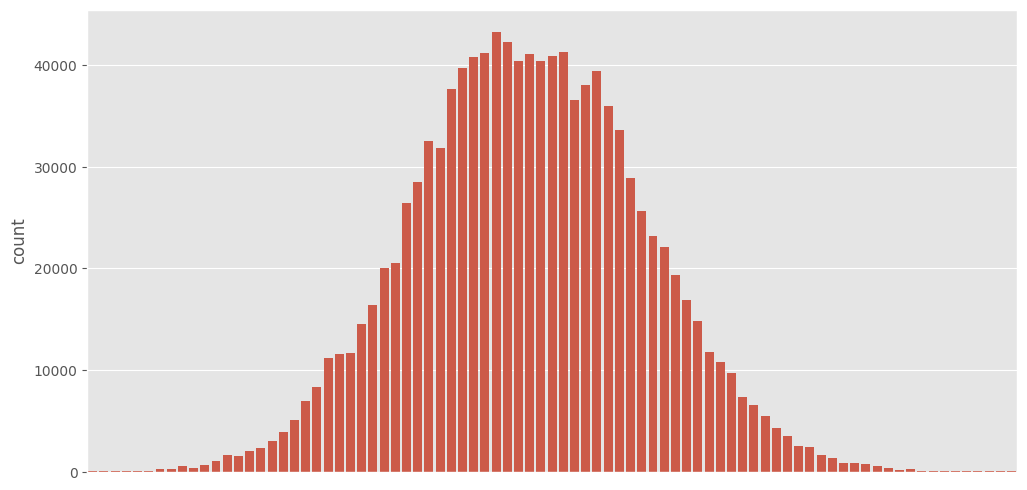

In [81]:
#count plot of Target data
plt.figure(figsize=(12, 6))
sns.countplot(x='FloodProbability', data=train_data)
plt.gca().axes.get_xaxis().set_visible(False)

plt.show()

In [46]:
col= ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors','FloodProbability']

In [47]:
train_data = train_data [col]

# ****Visualization on some taken variable

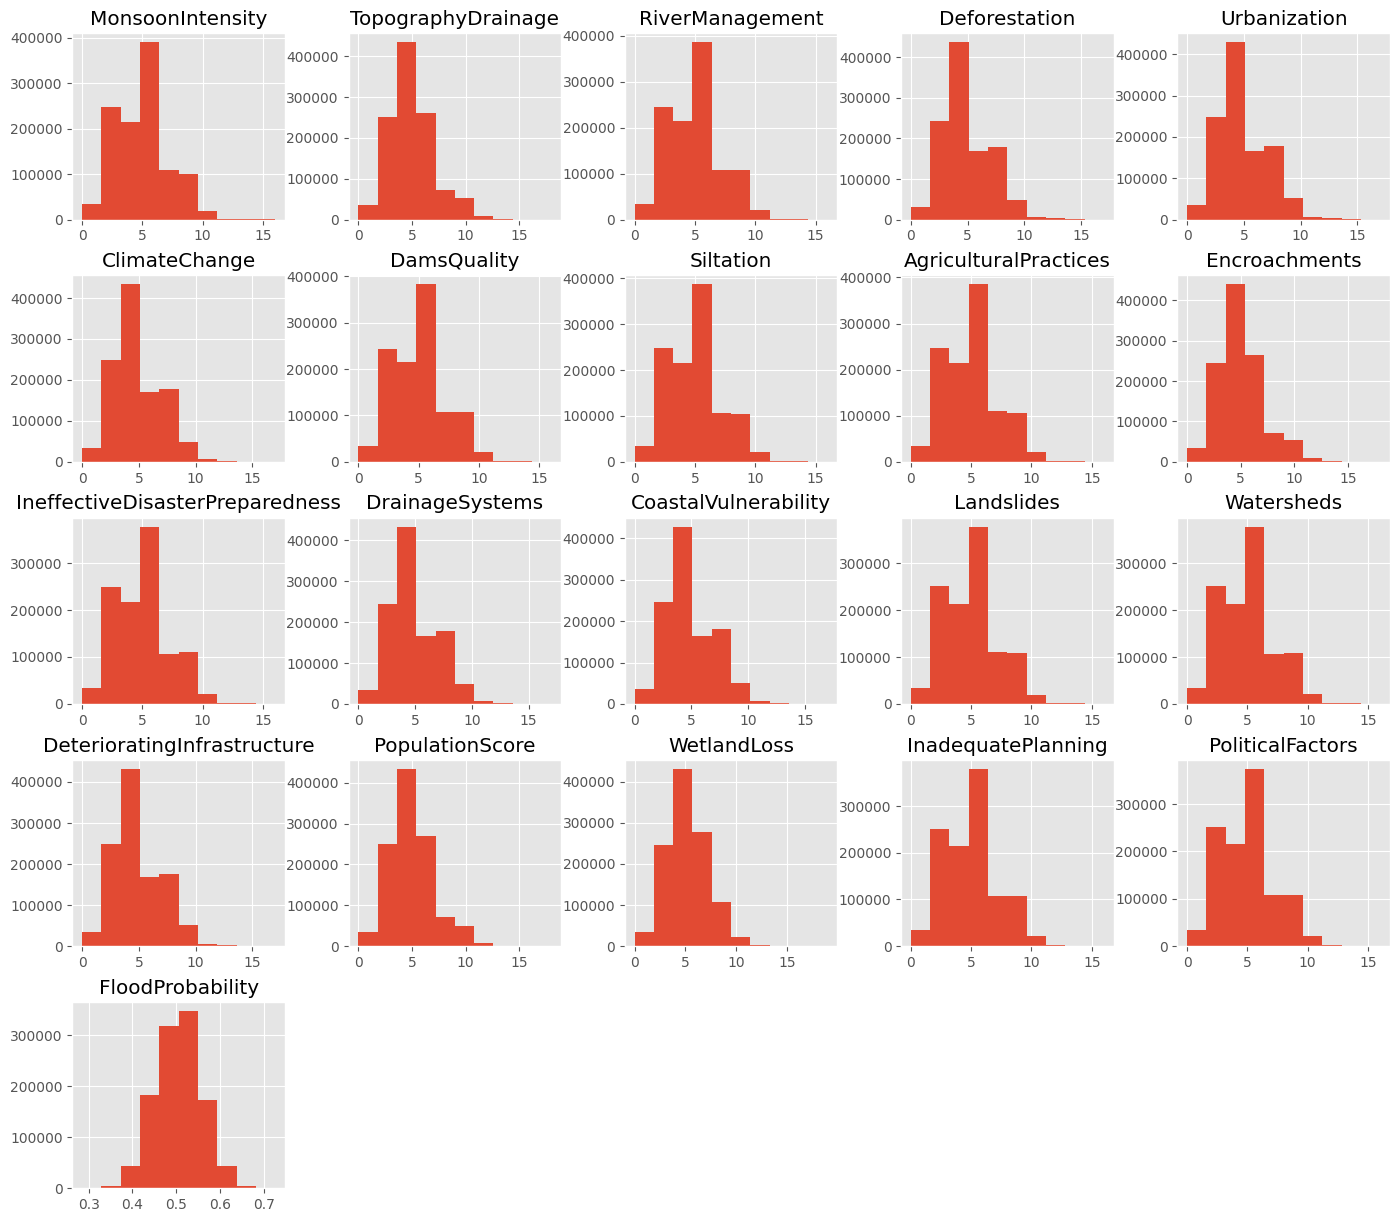

In [48]:
#histogram
train_data.hist(figsize=(17, 15))
plt.show()

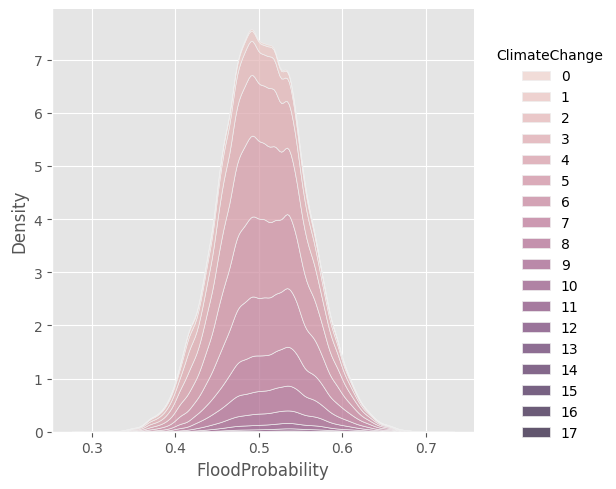

In [65]:
sns.displot(train_data, x="FloodProbability", hue="ClimateChange", kind="kde", multiple="stack")

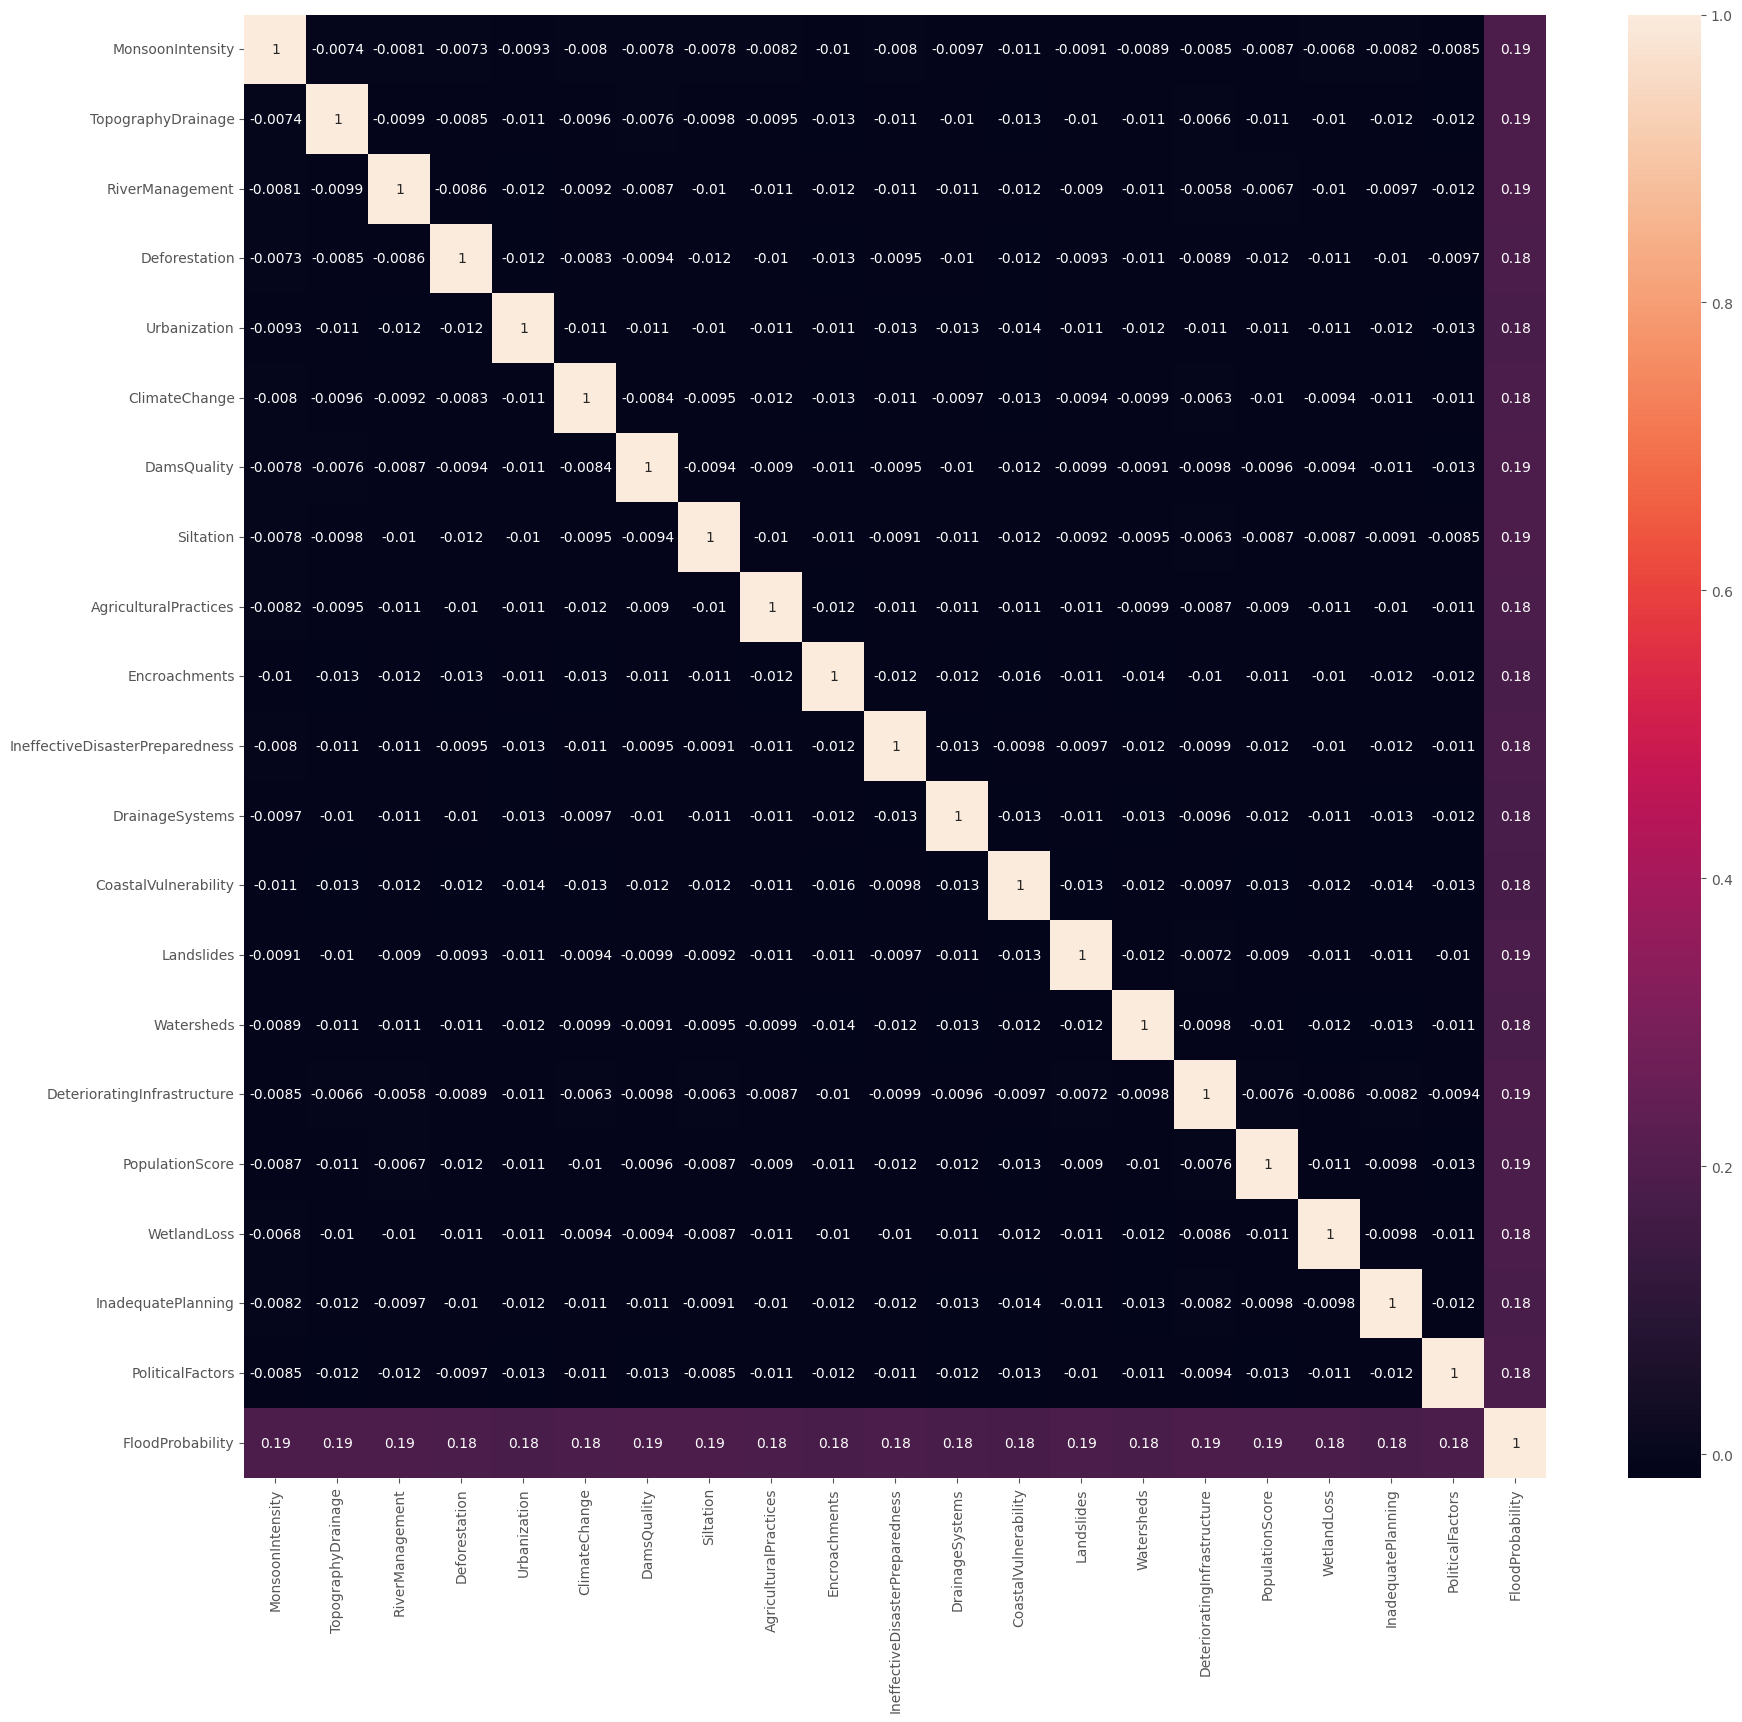

In [66]:
#Corralation
plt.figure(figsize=(21, 19))
corr = train_data.corr()
sns.heatmap(corr, annot=True )
plt.show()

# **Feature Selection**

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [60]:
features = ['MonsoonIntensity','TopographyDrainage','RiverManagement','DamsQuality','DeterioratingInfrastructure']
X = train_data[features]
y = train_data['FloodProbability']

In [61]:
#Split the data into test and train format

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

rf_model = RandomForestRegressor(random_state=1)
lr_model = LinearRegression()

lr_model.fit(X_train,y_train)

y_val_preds = lr_model.predict(X_val)
mae = mean_absolute_error(y_val,y_val_preds)
print ("Mean absolute Value:",mae)


# Rsquared Score for Linear Regression
r2_lr = r2_score(y_val, y_val_preds)
print("R-squared score for Linear Regression:", r2_lr)


Mean absolute Value: 0.03729761277281933
R-squared score for Linear Regression: 0.18187315883275412


In [69]:
X_test = test_data[features]
y_test = lr_model.predict(X_test)
y_val_preds = lr_model.predict(X_val)

In [67]:
# # Create a scatter plot with different colors for actual and predicted values
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x=y_val, y=y_val_preds, hue=[0, 1], palette=['blue', 'red'], alpha=0.7)
# plt.xlabel('Actual Flood Probability')
# plt.ylabel('Predicted Flood Probability')
# plt.title('Actual vs. Predicted Flood Probability')
# plt.legend(['Actual', 'Predicted'], loc='upper left')
# plt.grid(True)
# plt.show()

In [77]:
sns.lmplot(x="y_val", y="y_val_preds", hue="FloodProbability",data=train_data);

KeyError: "['y_val', 'y_val_preds'] not in index"

<ipython-input-62-3512ef6f7889>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axis1 = sns.distplot(y_val, hist=False, color='g', label='Actual values')
<ipython-input-62-3512ef6f7889>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val_preds, hist=False, color='r', label='Predicted va

<Axes: xlabel='FloodProbability', ylabel='Density'>

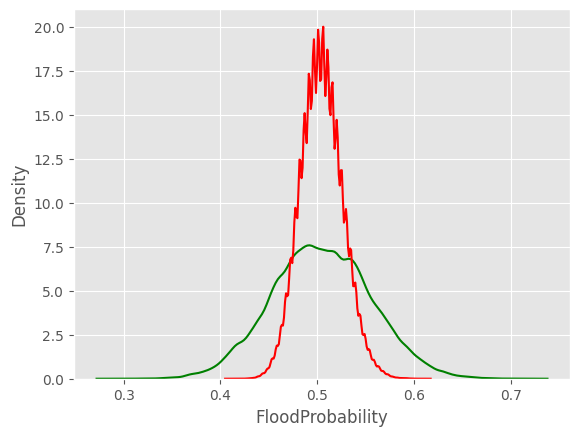

In [62]:
axis1 = sns.distplot(y_val, hist=False, color='g', label='Actual values')
sns.distplot(y_val_preds, hist=False, color='r', label='Predicted values', ax=axis1)

# Submission file

In [63]:
output = pd.read_csv("/kaggle/input/playground-series-s4e5/sample_submission.csv")
output.to_csv("submission.csv", index=False)
output

,id,FloodProbability
0,1117957,0.5
1,1117958,0.5
2,1117959,0.5
3,1117960,0.5
4,1117961,0.5
...,...,...
745300,1863257,0.5
745301,1863258,0.5
745302,1863259,0.5
745303,1863260,0.5
